### Homework 4

change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. Answer the following questions with cypher queries.

1) How many actors played in more than 2 movie ? Get their names and year they were born.

2) In how many movies did Tom hanks play ?

3) In average in how many movies do actors play in ?

4) In average how many actors are there in a movie ?

5) In average how many writers is needed to write a movie ?

6) What is the proportion of writers that also directed the movie ?

7) Do an histogram of the year of release for the movies.

8) Who are the 10 actors with the most movie played in

9) Delete every movie made by a director of your choosing

10) Give some statistics that you find interesting.

11) Sandbox exercise: think of a problematic and try to answer it.

In [ ]:
#1 

import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"),name="neo4j")
query = """
MATCH (m:Movie)<-[:ACTED_IN]-(play:Person)
with play, count(m) as film where film > 2
return play
"""
graph.run(query)

In [ ]:
#2

query = """
MATCH (m:Movie)<-[:ACTED_IN]-(play:Person{name:"Tom Hanks"})
with count(play.name) as nombre
return nombre
"""
graph.run(query)

# Tom Hanks played in 24 films.

In [ ]:
#3

query = """
MATCH (m:Movie)<-[:ACTED_IN]-(play:Person)
with play, count(m) as film
return avg(film)
"""
graph.run(query)

# In average, actors play in approximatively 1.686274 movies.

In [ ]:
#4

query = """
MATCH (m:Movie)<-[:ACTED_IN]-(play:Person)
with m, count(play.name) as nombre
return avg(nombre)
"""
graph.run(query)

# In average, there are approximatively 4.5263 actors in each movie.

In [ ]:
#5

query= """
MATCH (P:Person)-[:WROTE]->(m:Movie)
with m,count(P.name) as nombre
RETURN avg(nombre)
"""
graph.run(query)

# In average, there is approximatively 1.25 writers needed for one movie.

In [ ]:
#6

query1 ="""
MATCH (m:Movie)<-[:WROTE]-(d:DIRECTED)
with count(d.name) as nombre
return nombre
"""
graph.run(query1)

# We cannot find a coherent answer there, for the proportion of writers that also directed the movie.

In [ ]:
#7

import seaborn as sns
%matplotlib inline
query =""" Match (year:Movie) return year.released """
data =graph.run(query).to_data_frame()
sns.distplot(data['year.released'])

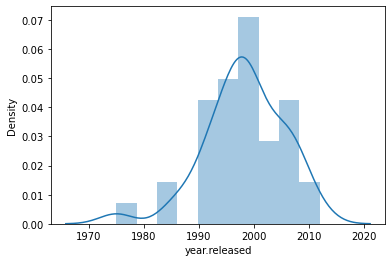

In [ ]:
#8 

query = """
MATCH (m:Movie)<-[:ACTED_IN]-(play:Person)
return play.name ,count(m) as nombre_films
Order by nombre_films desc
Limit 10
"""
graph.run(query)

# Actors with the most movie played in are Tom Hanks (24), Keanu Reeves (14), Meg Ryan (10), ...

In [ ]:
#9

query="""
MATCH (p:Person{name:"Jessica Thompson"})-[:DIRECTED]->(m:Movie)
DETACH DELETE m
"""
graph.run(query)

In [ ]:
#10

query1 = """
MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors),
(coActors)-[:ACTED_IN]->(m2)<-[:ACTED_IN]-(cocoActors) , (m:Movie)
WHERE NOT (tom)-[:ACTED_IN]->()<-[:ACTED_IN]-(cocoActors) AND tom <>cocoActors
RETURN coActors.name AS Recommended, count(*) AS Str, m.released
ORDER BY Str desc
"""
data = graph.run(query1).to_data_frame()
data.describe()

# In average, 10 individuals will not work with Tom Hanks afeter being advised.

## Homework 5

You will work on a Twitch dataset found [here](https://www.kaggle.com/andreagarritano/twitch-social-networks). The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node
from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

1) Give the IDs of the top 10 streamers that have atleast one collaboration.

2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

3) How many streamers has the tag "mature" ?

4) Is the collaboration correlated to the "mature" tag ?

5) Do partners collaborate more than non partners ?

6) Sandbox exercise : think of a problematic and try to answer it.

In [ ]:
import pandas as pd
import tqdm
import py2neo
from py2neo import Graph, Node, Relationship
import csv
import tqdm
import itertools

FR_target = pd.read_csv(r"C:\Users\ferve\Documents\NoSQL\Homeworks\FR_target.csv")

FR_target.drop_duplicates('new_id', inplace = True)

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"),name="neo4j")
graph.delete_all()

try:
    graph.run("CREATE CONSTRAINT ON (n:Streamer) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

transaction_list = []
iteration = 0

for row in tqdm.tqdm(FR_target.iterrows()):
    id_ = row[1]["id"]
    views = row[1]["views"]
    days = row[1]["days"]
    mature = row[1]["mature"]
    new_id = row[1]["new_id"]
    partner = row[1]["partner"]
    transaction_list.append({"id_":id_,"views":views,"days":days,"mature":mature,"new_id":new_id,"partner":partner})
    iteration += 1
    transaction = "UNWIND $json as data CREATE (n:Streamer) SET n = data"
    graph.run(transaction, json=transaction_list)
    transaction_list = []
    
    
graph.run(transaction, json=transaction_list)

print(FR_target)

In [ ]:
FR_edges = pd.read_csv(r"C:\Users\ferve\Documents\NoSQL\Homeworks\FR_edges.csv")
transaction_list = []
transaction = """UNWIND $json as data
    MATCH (a:Streamer),(b:Streamer)
    WHERE a.new_id = data.from AND b.new_id = data.to
    MERGE (a)-[r:RELATION]->(b)
    ON CREATE
    SET r.n_collab = 1
    ON MATCH
    SET r.n_collab = r.n_collab + 1
    """
it = 0
for edge in tqdm.tqdm(FR_edges.groupby(["from"])):
    related_ids = edge[1]["to"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"from":sh1,"to":sh2})
        it +=1
        graph.run(transaction, json=transaction_list)
        transaction_list = []
graph.run(transaction, json=transaction_list)

In [ ]:
#1

query = """MATCH (s:Streamer)
WHERE exists(s.id_)
RETURN s
ORDER BY s.views DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["s"])

# 71852533, 84934385, 24147592, 41719107, 174955366, 147337432, 40063341, 142506321, 29478753, 27528066

In [ ]:
#2 

import seaborn as sns
query = """
MATCH (p)
WITH p, size((p)-[:RELATION]->()) as degree
RETURN degree;
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")

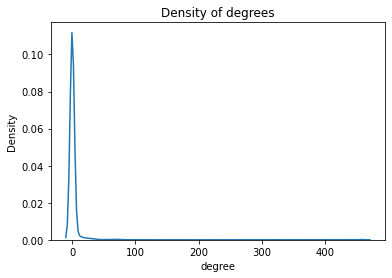

##### Loi d'échelle de puissance au point zéro avec y=1/(d)exposant(alpha) comme répartition de la distribution.

In [ ]:
#3

query = """
MATCH (s:Streamer)
WHERE s.mature=true
with count(s) as nombre
RETURN nombre
"""
graph.run(query)

# 2414 streamers have the tag "mature"

In [ ]:
#4

query = """
MATCH (p:Streamer)-[r:RELATION]->()
where p.mature = TRUE
RETURN p.mature
"""
graph.run(query)

# Yes it is

In [ ]:
#5

query = """
MATCH (s:Streamer)-[r:RELATION]->()
WHERE s.partner = True
with count(s) as nombre
return nombre
"""
graph.run(query)

query1 = """
MATCH (s:Streamer)-[r:RELATION]->()
WHERE s.partner = false
with count(s) as nombre
return nombre
"""
graph.run(query1)

# Partners do not collaborate more than non partners